# DEDS: Exercise 6
Vincent Itucal

## MLM Access Patterns

- **Get User by ID**  
    - use PK: `pk` query with `USER#{user_id}`
    - use SK: `sk` query with `PROFILE`
    - Sample return:  
      
    <table>
        <tr>
            <th></th>
            <th>PK</th>
            <th>SK</th>
            <th>Attribute columns</th>
        </tr>
        <tr>
            <td>1</td>
            <td>USER#001</td>
            <td>PROFILE</td>
            <td>...</td>
        </tr>
        <tr>
            <td>2</td>
            <td>USER#002</td>
            <td>PROFILE</td>
            <td>...</td>
        </tr>
    </table>

- **List Downline Member**  
    - GSI PK: `recruited_by` query with `USER#{user_id}`
    - Sample return:  
      
    <table>
        <tr>
            <th></th>
            <th>PK</th>
            <th>SK</th>
            <th>recruited_by (GSI)</th>
            <th>Attribute columns</th>
        </tr>
        <tr>
            <td>1</td>
            <td>USER#003</td>
            <td>PROFILE</td>
            <td>USER#001</td>
            <td>...</td>
        </tr>
        <tr>
            <td>2</td>
            <td>USER#004</td>
            <td>PROFILE</td>
            <td>USER#001</td>
            <td>...</td>
        </tr>
    </table>

- **Track Sales by Date**  
    - GSI PK: `DATE#{date}`, SK: `USER#{user_id}#SALE#{sale_id}`
    - Sample return:  
      
    <table>
        <tr>
            <th></th>
            <th>PK</th>
            <th>SK</th>
            <th>sale_date (GSI PK)</th>
            <th>sale_reference (GSI PK)</th>
            <th>Attribute columns</th>
        </tr>
        <tr>
            <td>1</td>
            <td>USER#004</td>
            <td>SALE#001</td>
            <td>DATE#20250219</td>
            <td>USER#004#SALE#001</td>
            <td>...</td>
        </tr>
    </table>

- **Get Sales By User ID**  
    - use PK: `pk` query with `USER#{user_id}`
    - LSI: `sale_reference` query with `USER#{user_id}SALE#{sale_id}`
    - Sample return:  
      
    <table>
        <tr>
            <th></th>
            <th>PK</th>
            <th>SK</th>
            <th>sale_reference (LSI)</th>
            <th>Attribute columns</th>
        </tr>
        <tr>
            <td>1</td>
            <td>USER#004</td>
            <td>SALE</td>
            <td>USER#004#SALE#001</td>
            <td>...</td>
        </tr>
    </table>

- **Search Users by Email/Phone**  
    - GSI1 PK: `email` query with `example@xyz.com`
    - Sample return (GSI1):  
      
    <table>
        <tr>
            <th></th>
            <th>PK</th>
            <th>SK</th>
            <th>email (GSI)</th>
            <th>Attribute columns</th>
        </tr>
        <tr>
            <td>1</td>
            <td>USER#003</td>
            <td>PROFILE</td>
            <td>example@xyz.com</td>
            <td>...</td>
        </tr>
    </table>
    
    - GSI2 PK: `phone` query with `0912345678`
    - Sample return (GSI2):  
      
    <table>
        <tr>
            <th></th>
            <th>PK</th>
            <th>SK</th>
            <th>phone (GSI)</th>
            <th>Attribute columns</th>
        </tr>
        <tr>
            <td>1</td>
            <td>USER#004</td>
            <td>PROFILE</td>
            <td>0912345678</td>
            <td>...</td>
        </tr>
    </table>


In [46]:
import boto3
import random
import json
import pandas as pd
from boto3.dynamodb.conditions import Key
from decimal import Decimal
from datetime import datetime, timedelta
from faker import Faker

In [23]:
dynamodb = boto3.resource('dynamodb')

## Screenshot of each tab of the console of the DynamoDB table

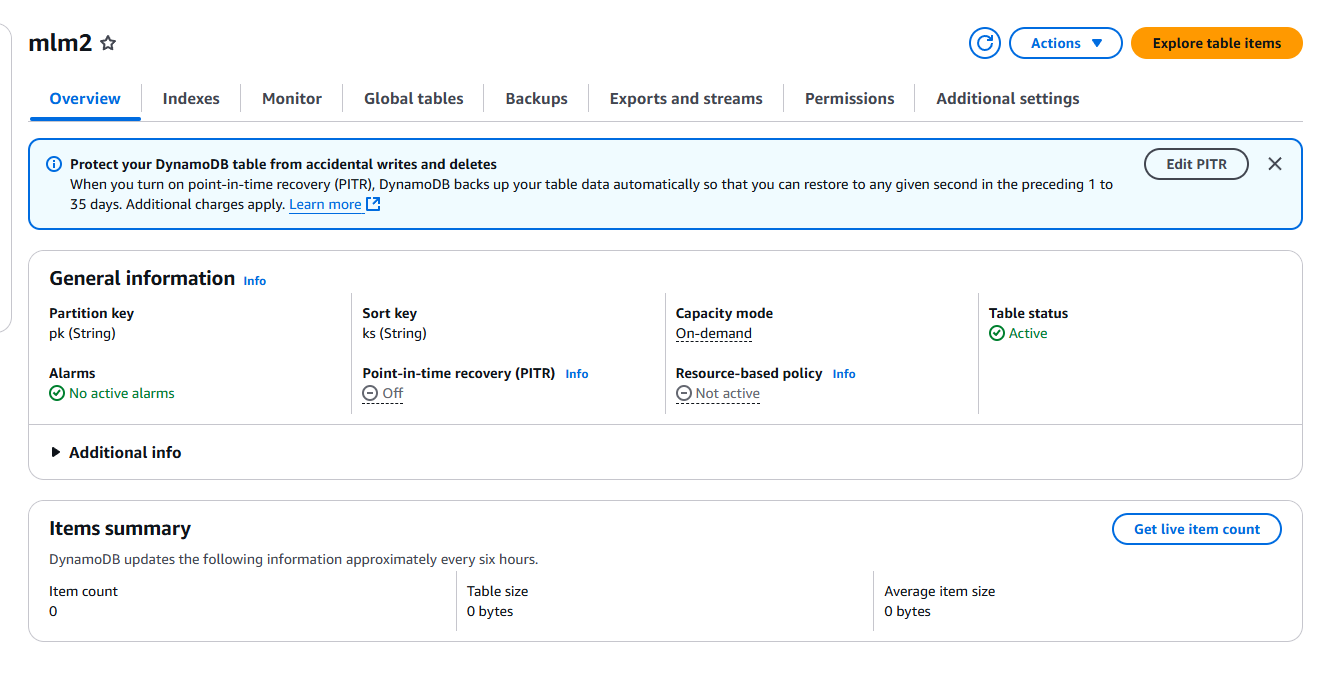
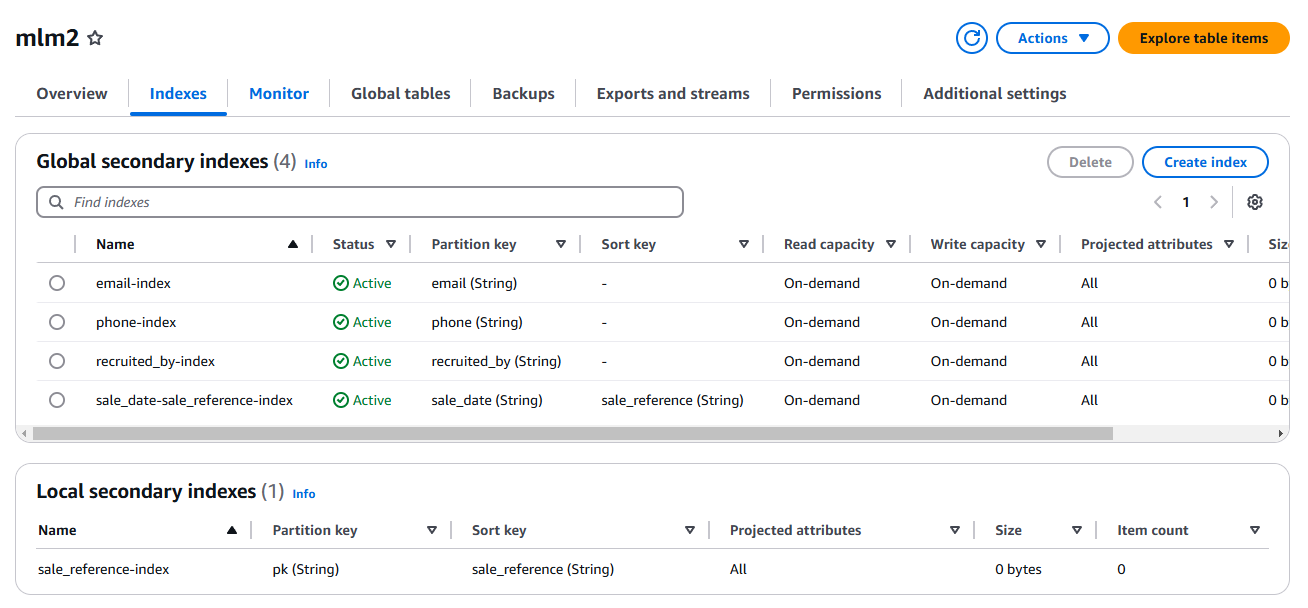

## Put or Insert operations used to load the data into DynamoDB


### Faker to generate inserts

In [30]:
faker = Faker()

users = []
users = []
for i in range(1, 81):
    user_id = f"{i:03d}"
    recruited_by = f"{random.randint(1, 5):03d}" if i > 2 else "001"  # First 5 users have no recruiter
    
    user = {
        "pk": f"USER#{user_id}",
        "sk": "PROFILE",
        "recruited_by": f"USER#{recruited_by}" if recruited_by else None,
        "name": faker.name(),
        "email": faker.email(),
        "phone": faker.phone_number(),
        "address": faker.address(),
        "created_at": faker.iso8601(),
    }
    users.append(user)
display(users[0])

{'pk': 'USER#001',
 'sk': 'PROFILE',
 'recruited_by': 'USER#001',
 'name': 'Jessica Flores',
 'email': 'ashleywoods@example.com',
 'phone': '001-348-872-5740x707',
 'address': 'PSC 3976, Box 7317\nAPO AP 34938',
 'created_at': '2024-09-21T00:43:11.534162'}

In [31]:
sales = []
for i in range(1, 21):  # Generate sales from SALE#001 to SALE#020
    sale_id = f"{i:03d}"  # SALE#001, SALE#002, ...
    user_id = f"{random.randint(1, 5):03d}"  # Assign sales to USER#001 to USER#005
    sale_date = (datetime.today() - timedelta(days=random.randint(1, 30))).strftime("%Y%m%d")  # Random last 30 days

    sale = {
        "pk": f"USER#{user_id}",
        "sk": f"SALE#{sale_id}",
        "sale_date": f"DATE#{sale_date}",  # GSI PK
        "sale_reference": f"USER#{user_id}#SALE#{sale_id}",  # GSI SK & LSI
        "amount": round(random.uniform(10, 500), 2),  # Random sale amount
        "item": faker.word(),
        "created_at": faker.iso8601(),
    }
    sale = json.loads(json.dumps(sale), parse_float=Decimal)
    sales.append(sale)
display(sales[0])

{'pk': 'USER#001',
 'sk': 'SALE#001',
 'sale_date': 'DATE#20250202',
 'sale_reference': 'USER#001#SALE#001',
 'amount': Decimal('283.18'),
 'item': 'management',
 'created_at': '1980-02-28T18:20:24.112711'}

In [36]:
table = dynamodb.Table("mlm")

In [39]:
for sale in sales:
    table.put_item(Item=sale)
for user in users:
    table.put_item(Item=user)

## Output of the contents of the table

In [48]:
scan_response = table.scan()
print(f"Item count: {scan_response['Count']}")
display(pd.DataFrame(scan_response['Items']))

Item count: 100


,created_at,sk,address,recruited_by,pk,email,phone,name,sale_date,amount,item,sale_reference
0,1986-07-28T07:43:44.911177,PROFILE,USS Bright\nFPO AE 09115,USER#003,USER#017,carterjonathan@example.org,697.643.6574x251,Lisa Johnson,NaN,NaN,NaN,NaN
1,1989-02-20T06:17:41.871887,PROFILE,"PSC 0972, Box 0476\nAPO AA 44654",USER#005,USER#052,rileyharris@example.org,+1-359-841-9628x98396,Eric Cooper,NaN,NaN,NaN,NaN
2,1985-06-19T05:04:09.354295,PROFILE,"43432 Miller Walk\nNew Marcusstad, CA 31572",USER#003,USER#077,elizabeth31@example.org,+1-215-885-8220x67174,Lori Espinoza,NaN,NaN,NaN,NaN
3,2002-10-12T14:30:47.649668,PROFILE,"4514 Bonnie Bridge\nNorth Tamara, PR 74507",USER#001,USER#009,lvillarreal@example.org,342.687.0630x6440,William Smith,NaN,NaN,NaN,NaN
4,2009-09-20T21:21:42.790504,PROFILE,"6168 Jay Plaza\nReedton, PA 25862",USER#005,USER#078,devinrivera@example.net,+1-794-374-5581x541,Natasha Flores,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2009-10-17T07:59:01.536049,SALE#010,NaN,NaN,USER#005,NaN,NaN,NaN,DATE#20250113,446.13,hold,USER#005#SALE#010
96,2011-08-29T09:22:52.718027,PROFILE,"3346 Black Creek\nLake Anna, KS 14903",USER#005,USER#012,rachel94@example.net,+1-979-457-8260x44302,Danielle Pineda,NaN,NaN,NaN,NaN
97,2007-11-06T17:51:44.412900,PROFILE,"9836 Yolanda Lock Suite 495\nWest Jennifer, IN...",USER#003,USER#071,emedina@example.com,988-549-9473x69972,Hannah Jones,NaN,NaN,NaN,NaN
98,1996-03-19T10:49:08.920029,PROFILE,"82861 Gutierrez Loop Apt. 591\nSouth Noahton, ...",USER#004,USER#051,brian17@example.org,375-974-5306x68680,Suzanne Moreno,NaN,NaN,NaN,NaN


## Access pattern queries

### Get User by ID

In [51]:
resp = table.query(
    KeyConditionExpression=Key("pk").eq(f"USER#001") & Key("sk").eq("PROFILE")
)
display(pd.DataFrame(resp['Items']))

,created_at,sk,address,recruited_by,pk,email,phone,name
0,2024-09-21T00:43:11.534162,PROFILE,"PSC 3976, Box 7317\nAPO AP 34938",USER#001,USER#001,ashleywoods@example.com,001-348-872-5740x707,Jessica Flores


### List Downline member

In [53]:
resp = table.query(
    IndexName="recruited_by-index",
    KeyConditionExpression=Key("recruited_by").eq(f"USER#001")
)
display(pd.DataFrame(resp['Items']))

,created_at,sk,recruited_by,address,email,pk,phone,name
0,1973-05-17T00:18:07.656590,PROFILE,USER#001,Unit 1757 Box 2013\nDPO AE 01983,craigdaniel@example.com,USER#015,7293192354,Ryan Spears
1,2002-12-16T16:07:36.313981,PROFILE,USER#001,Unit 1198 Box 2510\nDPO AA 45036,sanderson@example.com,USER#038,826-599-7509x36663,Renee Lopez
2,2014-11-15T23:14:19.257127,PROFILE,USER#001,"81977 Smith Shores Apt. 143\nSouth Lisa, OR 45314",robertsjennifer@example.org,USER#055,(693)480-0690,Patricia Melton
3,1983-05-09T03:18:53.358520,PROFILE,USER#001,"08915 Bell Stravenue Apt. 232\nPatriciastad, V...",janeperez@example.org,USER#074,+1-444-351-3924x665,Michael Hudson
4,1999-07-11T19:40:07.353976,PROFILE,USER#001,"962 Christine Street\nNew Virginiaport, ID 67153",allensandra@example.org,USER#002,+1-716-521-8510x976,Maurice Robinson
5,2024-09-21T00:43:11.534162,PROFILE,USER#001,"PSC 3976, Box 7317\nAPO AP 34938",ashleywoods@example.com,USER#001,001-348-872-5740x707,Jessica Flores
6,1984-09-19T10:34:14.846001,PROFILE,USER#001,"457 Katherine Road Suite 414\nSamanthaton, CT ...",troyarroyo@example.org,USER#027,256-962-6683x5468,Mrs. Sara Garcia
7,2017-08-19T17:26:32.777062,PROFILE,USER#001,5054 Becker Burg Apt. 055\nSouth Jenniferborou...,nicolejohnson@example.net,USER#004,6477110107,Daniel Davis
8,2012-01-13T02:47:29.682590,PROFILE,USER#001,"241 Michael Terrace Suite 189\nPort Bryantown,...",crossrichard@example.com,USER#066,+1-382-217-9316x243,Marissa Hill MD
9,2001-06-11T23:18:33.025254,PROFILE,USER#001,"8117 Jonathan Gateway\nWest Steven, PA 50089",brittany65@example.org,USER#068,001-957-528-6159,Becky Landry


### Track Sales by Date

In [54]:
resp = table.query(
    IndexName="sale_date-sale_reference-index",
    KeyConditionExpression=Key("sale_date").eq(f"DATE#20250202")
)
display(pd.DataFrame(resp['Items']))

,created_at,sale_date,amount,sk,item,pk,sale_reference
0,1980-02-28T18:20:24.112711,DATE#20250202,283.18,SALE#001,management,USER#001,USER#001#SALE#001
1,1973-11-30T05:16:55.378551,DATE#20250202,236.71,SALE#016,onto,USER#002,USER#002#SALE#016


### Get Sales By User ID

In [57]:
resp = table.query(
    IndexName="sale_reference-index",
    KeyConditionExpression=Key("pk").eq("USER#001") & Key("sale_reference").begins_with("USER#001")
)
display(pd.DataFrame(resp['Items']))

,created_at,sale_date,amount,sk,item,pk,sale_reference
0,1980-02-28T18:20:24.112711,DATE#20250202,283.18,SALE#001,management,USER#001,USER#001#SALE#001
1,1998-05-29T23:16:50.553729,DATE#20250209,268.83,SALE#004,apply,USER#001,USER#001#SALE#004
2,2012-07-11T01:58:05.841327,DATE#20250117,53.35,SALE#012,join,USER#001,USER#001#SALE#012
3,2008-04-26T22:25:48.197514,DATE#20250210,282.57,SALE#013,government,USER#001,USER#001#SALE#013
4,2001-11-15T21:12:18.026192,DATE#20250206,101.57,SALE#015,short,USER#001,USER#001#SALE#015
5,1986-05-06T11:24:54.856152,DATE#20250122,368.29,SALE#019,bring,USER#001,USER#001#SALE#019


### Serach users by email/phone

In [59]:
resp = table.query(
    IndexName="email-index",
    KeyConditionExpression=Key("email").eq("ashleywoods@example.com")
)
display(pd.DataFrame(resp['Items']))

,created_at,sk,address,recruited_by,email,pk,phone,name
0,2024-09-21T00:43:11.534162,PROFILE,"PSC 3976, Box 7317\nAPO AP 34938",USER#001,ashleywoods@example.com,USER#001,001-348-872-5740x707,Jessica Flores


In [60]:
resp = table.query(
    IndexName="phone-index",
    KeyConditionExpression=Key("phone").eq("001-348-872-5740x707")
)
display(pd.DataFrame(resp['Items']))

,created_at,sk,address,recruited_by,email,pk,phone,name
0,2024-09-21T00:43:11.534162,PROFILE,"PSC 3976, Box 7317\nAPO AP 34938",USER#001,ashleywoods@example.com,USER#001,001-348-872-5740x707,Jessica Flores
